# Appliances energy prediction 


The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. 

The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. 

Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

### Attribute Information
- **date**: time year-month-day hour:minute:second
- **Appliances**: energy use in Wh
- **lights**: energy use of light fixtures in the house in Wh
- **T1**: Temperature in kitchen area, in Celsius
- **RH_1**: Humidity in kitchen area, in %
- **T2**: Temperature in living room area, in Celsius
- **RH_2**: Humidity in living room area, in %
- **T3**: Temperature in laundry room area
- **RH_3**: Humidity in laundry room area, in %
- **T4**: Temperature in office room, in Celsius
- **RH_4**: Humidity in office room, in %
- **T5**: Temperature in bathroom, in Celsius
- **RH_5**: Humidity in bathroom, in %
- **T6**: Temperature outside the building (north side), in Celsius
- **RH_6**: Humidity outside the building (north side), in %
- **T7**: Temperature in ironing room , in Celsius
- **RH_7**: Humidity in ironing room, in %
- **T8**: Temperature in teenager room 2, in Celsius
- **RH_8**: Humidity in teenager room 2, in %
- **T9**: Temperature in parents room, in Celsius
- **RH_9**: Humidity in parents room, in %
- **To**: Temperature outside (from Chievres weather station), in Celsius
- **Pressure**: (from Chievres weather station), in mm Hg
- **RH_out**: Humidity outside (from Chievres weather station), in %
- **Wind speed**: (from Chievres weather station), in m/s
- **Visibility**: (from Chievres weather station), in km
- **Tdewpoint**: (from Chievres weather station), Â°C
- **rv1**: Random variable 1, nondimensional
- **rv2**: Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

import sklearn
from sklearn.metrics import mean_squared_error
from scipy.stats import variation, boxcox
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

plt.rc('font', size=16)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=18)
plt.rc('figure', figsize=(16,16))
plt.style.use('seaborn-whitegrid')

pd.set_option('display.precision', 1)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df['energy'] = df['Appliances'] + df['lights']

In [3]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,energy
0,2016-01-11 17:00:00,60,30,19.9,47.6,19.2,44.8,19.8,44.7,19.0,45.6,17.2,55.2,7.0,84.3,17.2,41.6,18.2,48.9,17.0,45.5,6.6,733.5,92.0,7.0,63.0,5.3,13.3,13.3,90
1,2016-01-11 17:10:00,60,30,19.9,46.7,19.2,44.7,19.8,44.8,19.0,46.0,17.2,55.2,6.8,84.1,17.2,41.6,18.2,48.9,17.1,45.6,6.5,733.6,92.0,6.7,59.2,5.2,18.6,18.6,90
2,2016-01-11 17:20:00,50,30,19.9,46.3,19.2,44.6,19.8,44.9,18.9,45.9,17.2,55.1,6.6,83.2,17.2,41.4,18.2,48.7,17.0,45.5,6.4,733.7,92.0,6.3,55.3,5.1,28.6,28.6,80
3,2016-01-11 17:30:00,50,40,19.9,46.1,19.2,44.6,19.8,45.0,18.9,45.7,17.2,55.1,6.4,83.4,17.1,41.3,18.1,48.6,17.0,45.4,6.2,733.8,92.0,6.0,51.5,5.0,45.4,45.4,90
4,2016-01-11 17:40:00,60,40,19.9,46.3,19.2,44.5,19.8,45.0,18.9,45.5,17.2,55.1,6.4,84.9,17.2,41.2,18.1,48.6,17.0,45.4,6.1,733.9,92.0,5.7,47.7,4.9,10.1,10.1,100


In [4]:
# df.isnull().sum()

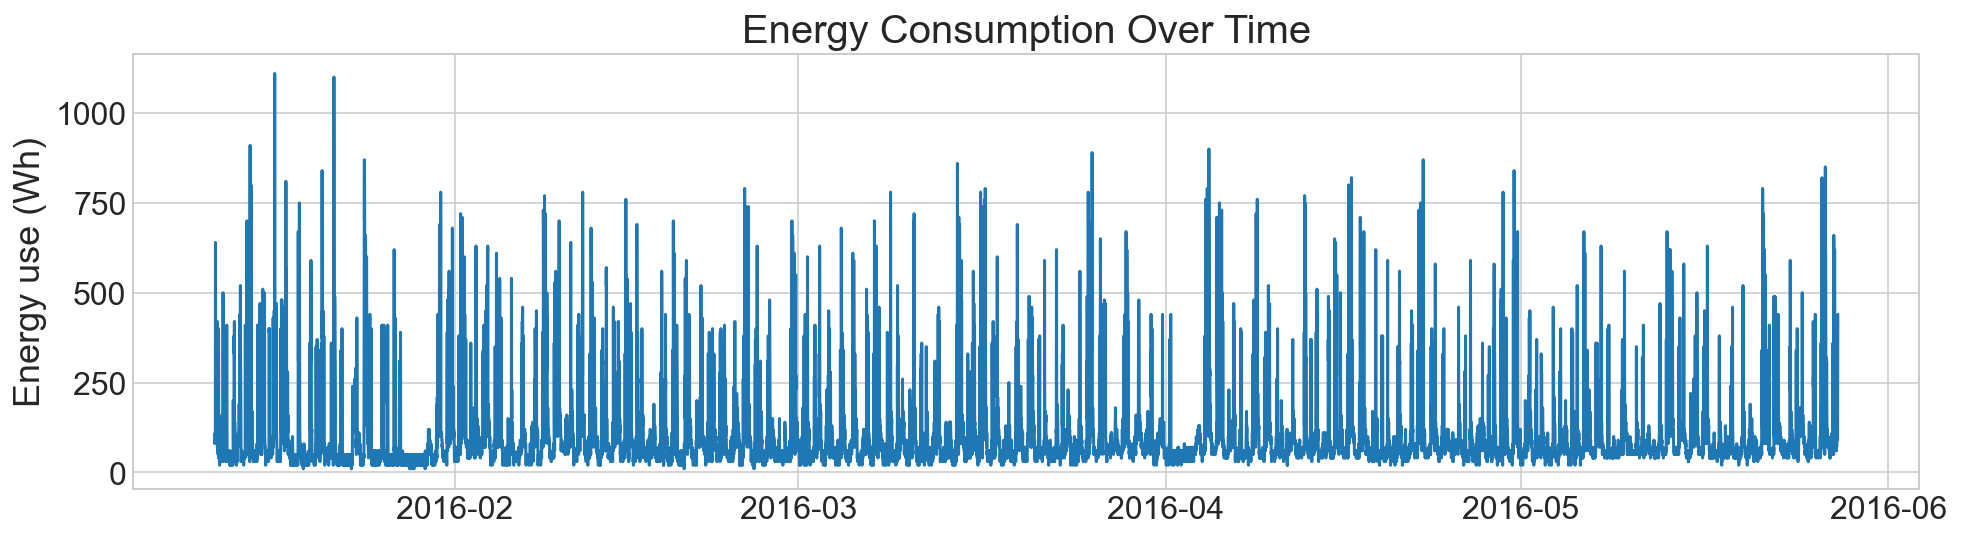

In [5]:
plt.figure(figsize=(16,4))
plt.plot(df['date'], df['energy'])
plt.title("Energy Consumption Over Time", fontsize=20)
plt.ylabel('Energy use (Wh)', fontsize=18)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.show()

Group by hour because there are missing 10-min interval datapoints

In [6]:
df_daily = pd.DataFrame(df.resample('D', on='date').mean()) 
n_days = len(df_daily)
print("{} days total".format(n_days))

138 days total


In [7]:
df_hourly = pd.DataFrame(df.resample('H', on='date').mean()) 
target = pd.DataFrame(df_hourly['energy'])

### Time Series Decomposition

In [8]:
decomposition = seasonal_decompose(x=target, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

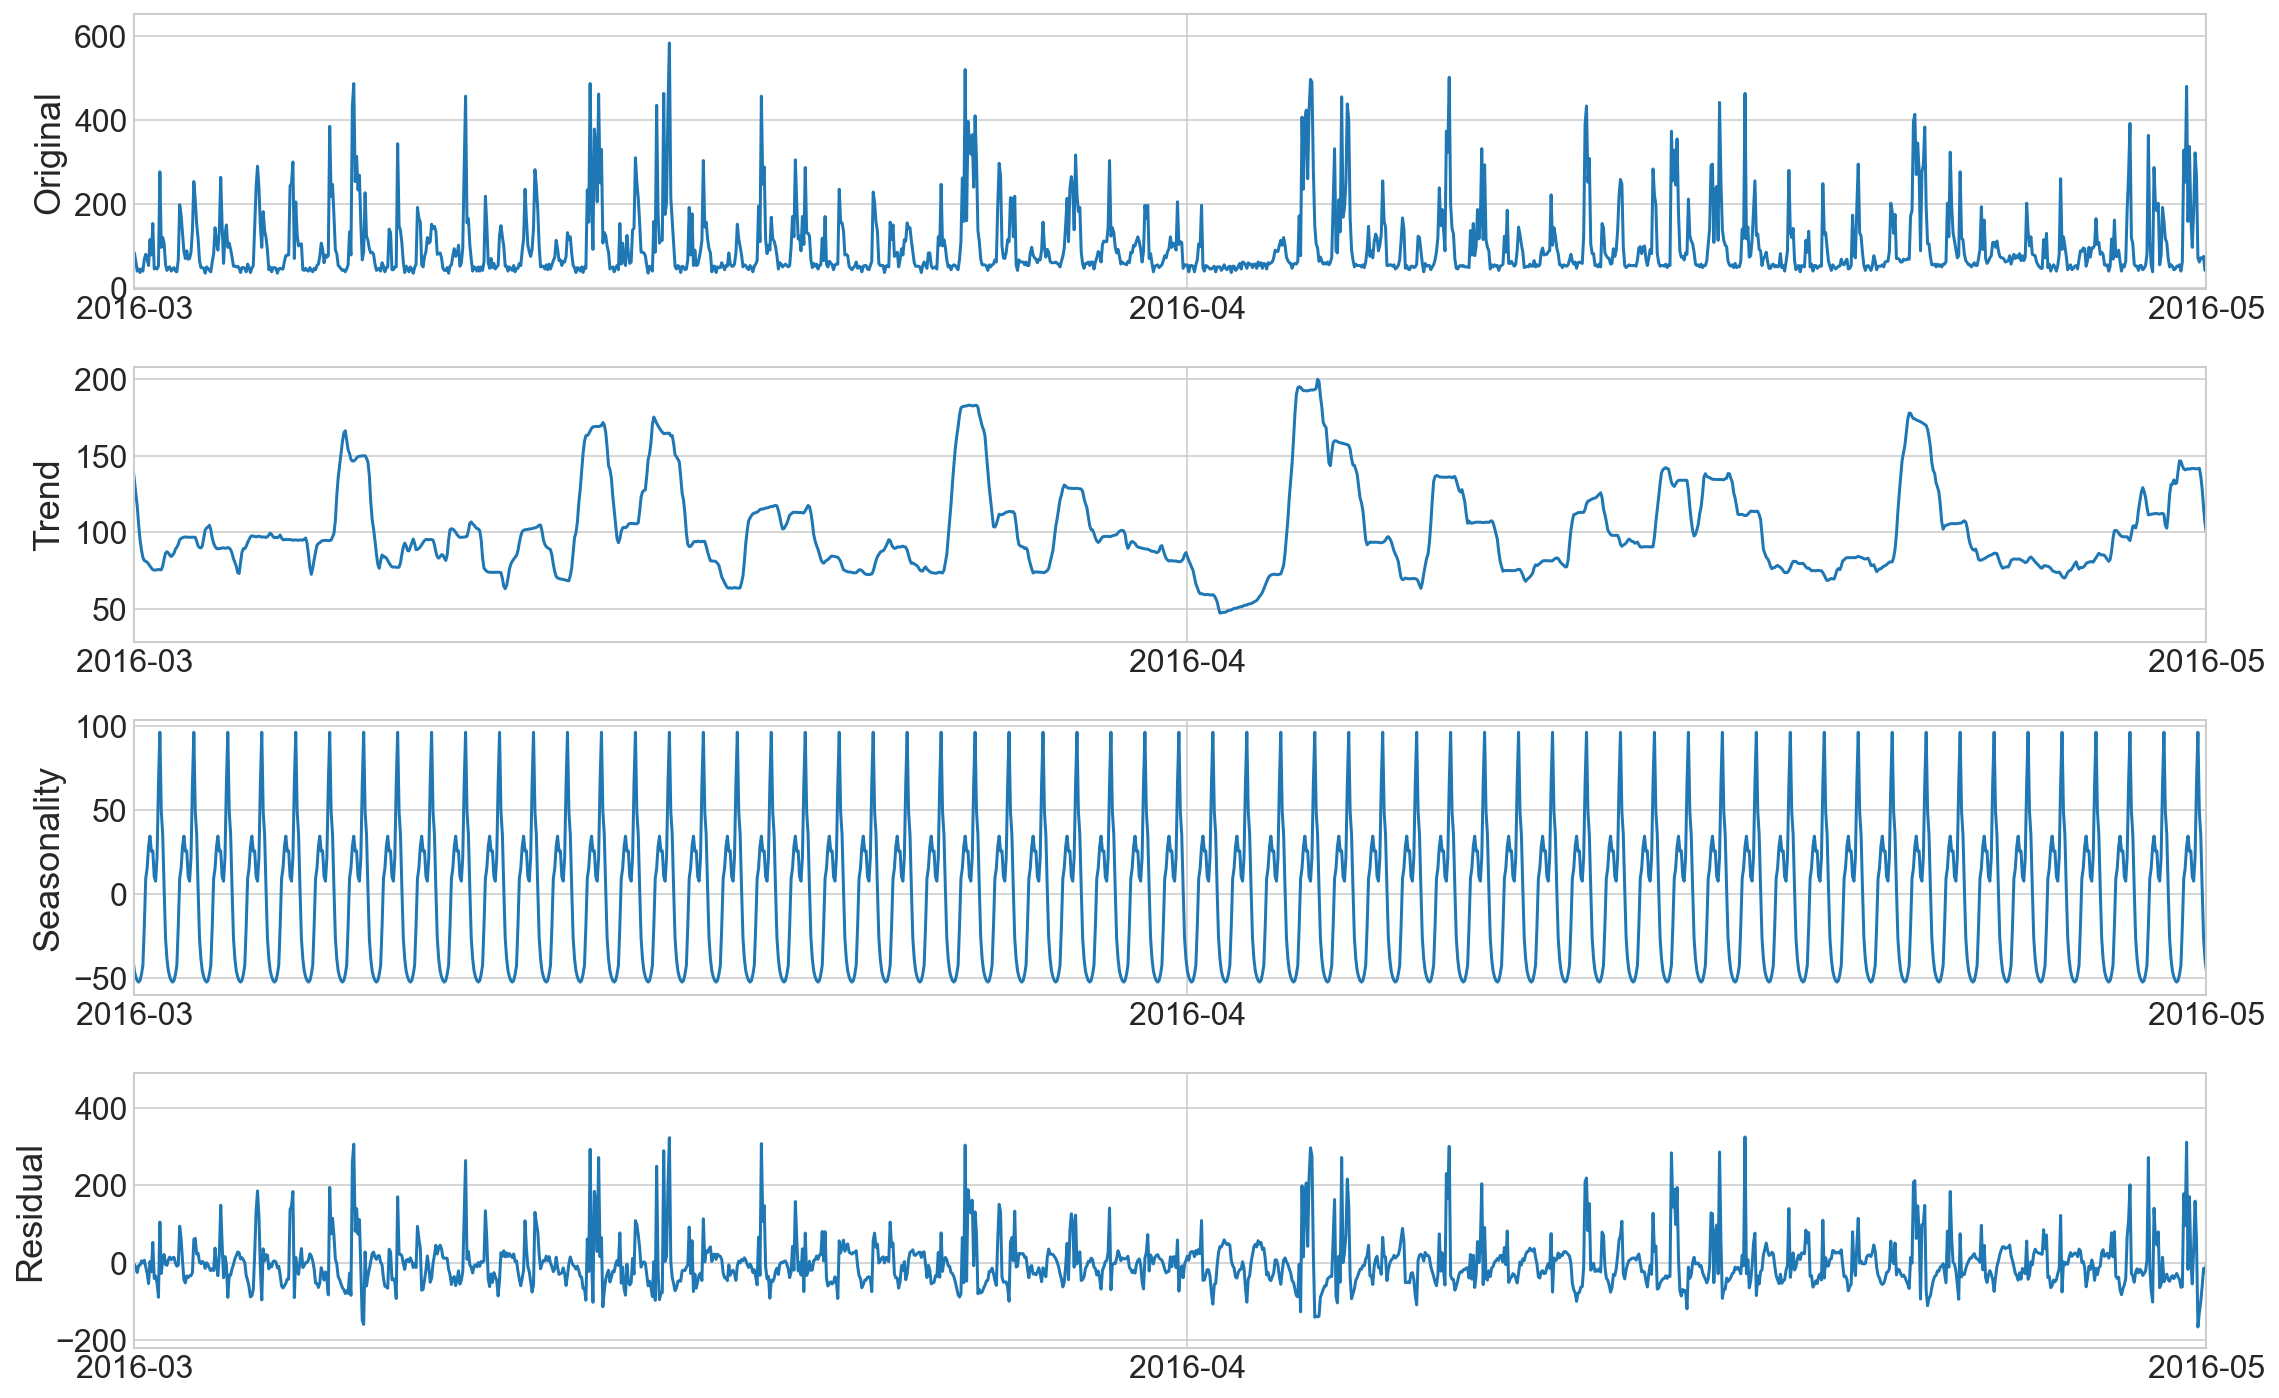

In [10]:
# Plot gathered statistics
start = datetime.date(2016, 3, 1)
end = datetime.date(2016, 5, 1)
plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(df_hourly.index, df_hourly['energy'])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([start, end])
plt.ylabel("Original")
plt.subplot(412)
plt.plot(trend)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([start, end])
plt.ylabel("Trend")
plt.subplot(413)
plt.plot(seasonal)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([start, end])
plt.ylabel("Seasonality")
plt.subplot(414)
plt.plot(residual)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([start, end])
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

Explore summary statistics

In [11]:
# summary statistics
print(residual.describe())

count    3266.0
mean       -0.1
std        64.3
min      -187.1
25%       -37.5
50%        -9.4
75%        20.7
max       457.7
Name: resid, dtype: float64


In [12]:
# We want to see a fixed variance
feb_2016_series = residual['02-2016']
mar_2016_series = residual['03-2016']
apr_2016_series = residual['04-2016']
may_2016_series = residual['05-2016']

print("Feb 2016 mean is {:.2f}, std: {:.2f}, variance: {:.2f}".format(
    np.mean(feb_2016_series), np.std(feb_2016_series), np.var(feb_2016_series)))
print("Mar 2016 mean is {:.2f}, std: {:.2f}, variance: {:.2f}".format(
    np.mean(mar_2016_series), np.std(mar_2016_series), np.var(mar_2016_series)))
print("Apr 2016 mean is {:.2f}, std: {:.2f}, variance: {:.2f}".format(
    np.mean(apr_2016_series), np.std(apr_2016_series), np.var(apr_2016_series)))
print("May 2016 mean is {:.2f}, std: {:.2f}, variance: {:.2f}".format(
    np.mean(may_2016_series), np.std(may_2016_series), np.var(may_2016_series)))

Feb 2016 mean is 0.16, std: 60.80, variance: 3697.06
Mar 2016 mean is -0.31, std: 60.39, variance: 3646.72
Apr 2016 mean is 0.09, std: 66.10, variance: 4368.96
May 2016 mean is -0.30, std: 50.82, variance: 2582.81


# Forecasting: Simple Methods

In [13]:
TRAIN_LEN = round(0.7976 * len(target))

train_df = target[:TRAIN_LEN]
test_df = target[TRAIN_LEN:]

n_days_train = len(pd.DataFrame(train_df.reset_index().resample('D', on='date').mean()))
n_days_test = len(pd.DataFrame(test_df.reset_index().resample('D', on='date').mean()))
print("{} train days, {} test days".format(n_days_train, n_days_test))

111 train days, 28 test days


### Simple average method

In [15]:
y_hat_avg = test_df.copy()
y_hat_avg['avg_forecast'] = train_df['energy'].mean()

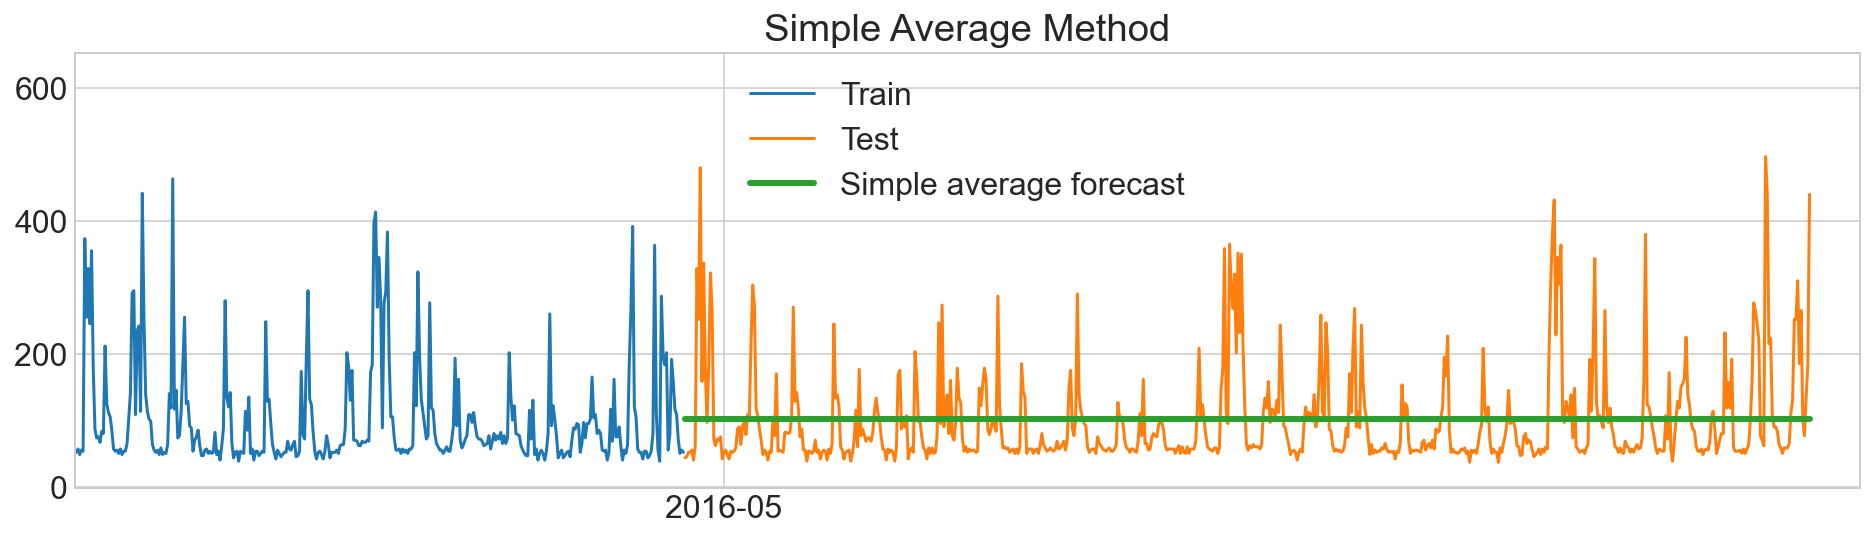

In [21]:
# Plot train, test and forecast

plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast', lw=3)
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 5, 29)])
plt.show()

In [22]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_avg['avg_forecast'])/test_df['energy'])*100,2)

results = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5


### Simple moving average method

In [23]:
y_hat_sma = target.copy()
ma_window = 24
y_hat_sma['sma_forecast'] = target['energy'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][TRAIN_LEN:] = y_hat_sma['sma_forecast'][TRAIN_LEN-1]

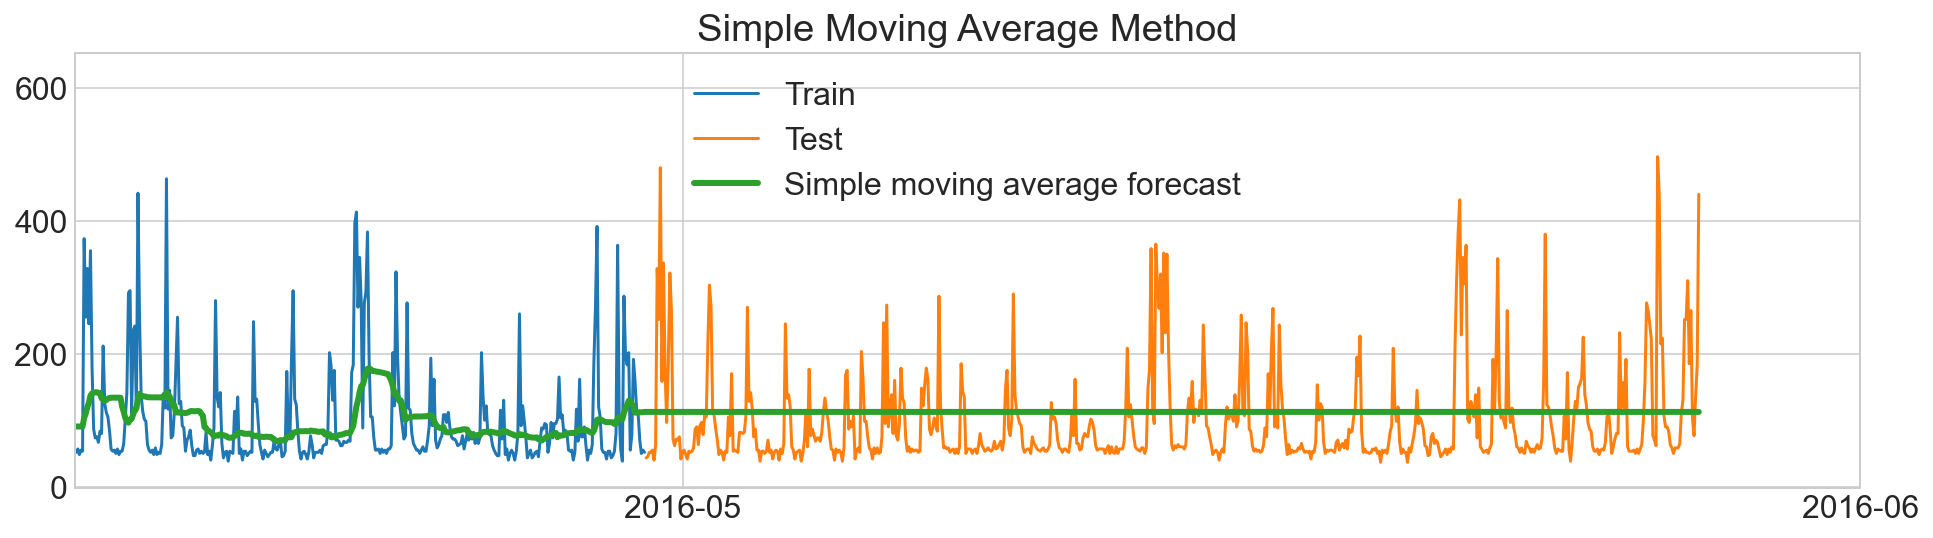

In [24]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast', lw=3)
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [25]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_sma['sma_forecast'][TRAIN_LEN:])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_sma['sma_forecast'][TRAIN_LEN:])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9


# Forecasting: Exponential Smoothing Techniques

### Simple exponential smoothing

In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train_df)
model_fit = model.fit(optimized=True)
print(model_fit.params)

y_hat_ses = test_df.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test_df))

{'smoothing_level': 0.5862767159109411, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 139.45292271564318, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


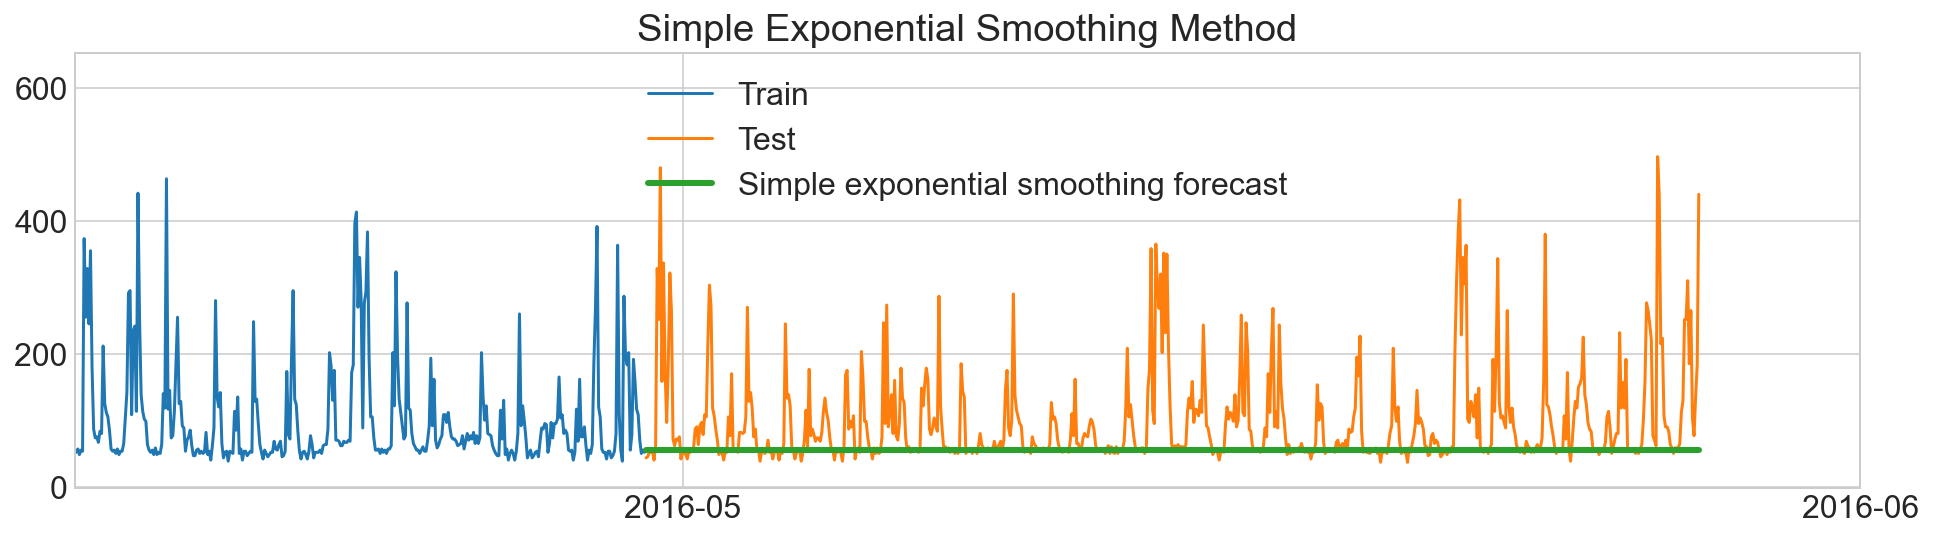

In [27]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast', lw=3)
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [28]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_ses['ses_forecast'])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8


### Holt's method with trend

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(np.asarray(train_df), seasonal_periods=24 , trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)

y_hat_holt = test_df.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test_df))

{'smoothing_level': 0.5883430378136602, 'smoothing_trend': 0.017650541397237915, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 189.2721215694118, 'initial_trend': -0.7067579543254654, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


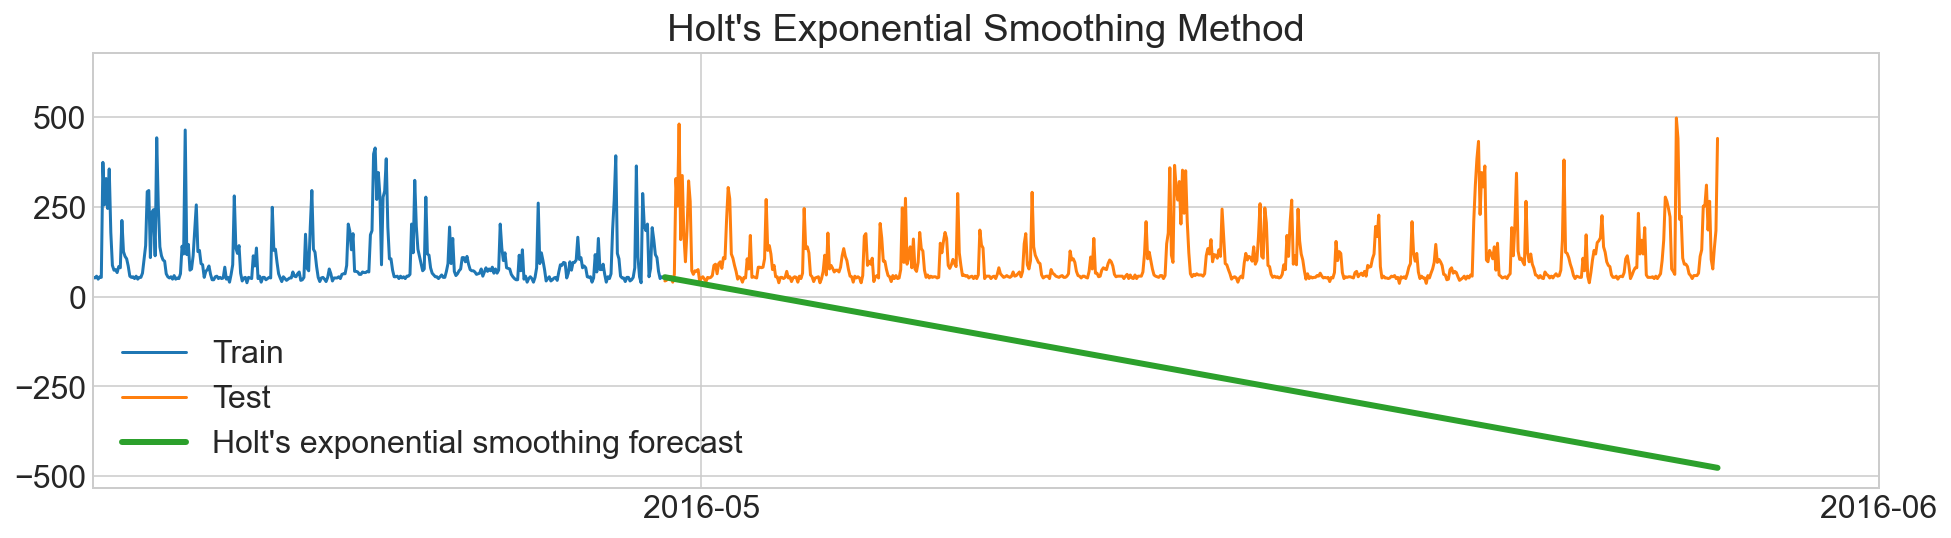

In [30]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast', lw=3)
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [31]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_holt['holt_forecast'])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7


### Holt Winters' additive method with trend and seasonality 

In [32]:
y_hat_hwa = test_df.copy()
# model = ExponentialSmoothing(np.asarray(train_df['energy']), seasonal_periods=n_days_train, trend=None, seasonal='add')
model = ExponentialSmoothing(np.asarray(train_df), seasonal_periods=24, trend=None, seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test_df))

{'smoothing_level': 0.45402442859116826, 'smoothing_trend': nan, 'smoothing_seasonal': 0.07270959634731033, 'damping_trend': nan, 'initial_level': 113.80352754731996, 'initial_trend': nan, 'initial_seasons': array([ 33.62894574,  83.91244857,  80.724577  ,  77.84621469,
        36.67612009,  15.57185096, -37.48825768, -43.0669363 ,
       -42.71493697, -62.19528172, -64.84421111, -66.45591005,
       -69.15033286, -63.89597781,  -0.13297934,  40.2842016 ,
        32.30770824,  42.92278044,  36.38734935,  34.66541612,
        22.22506667, -10.81578499, -38.33129551, -49.6762326 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


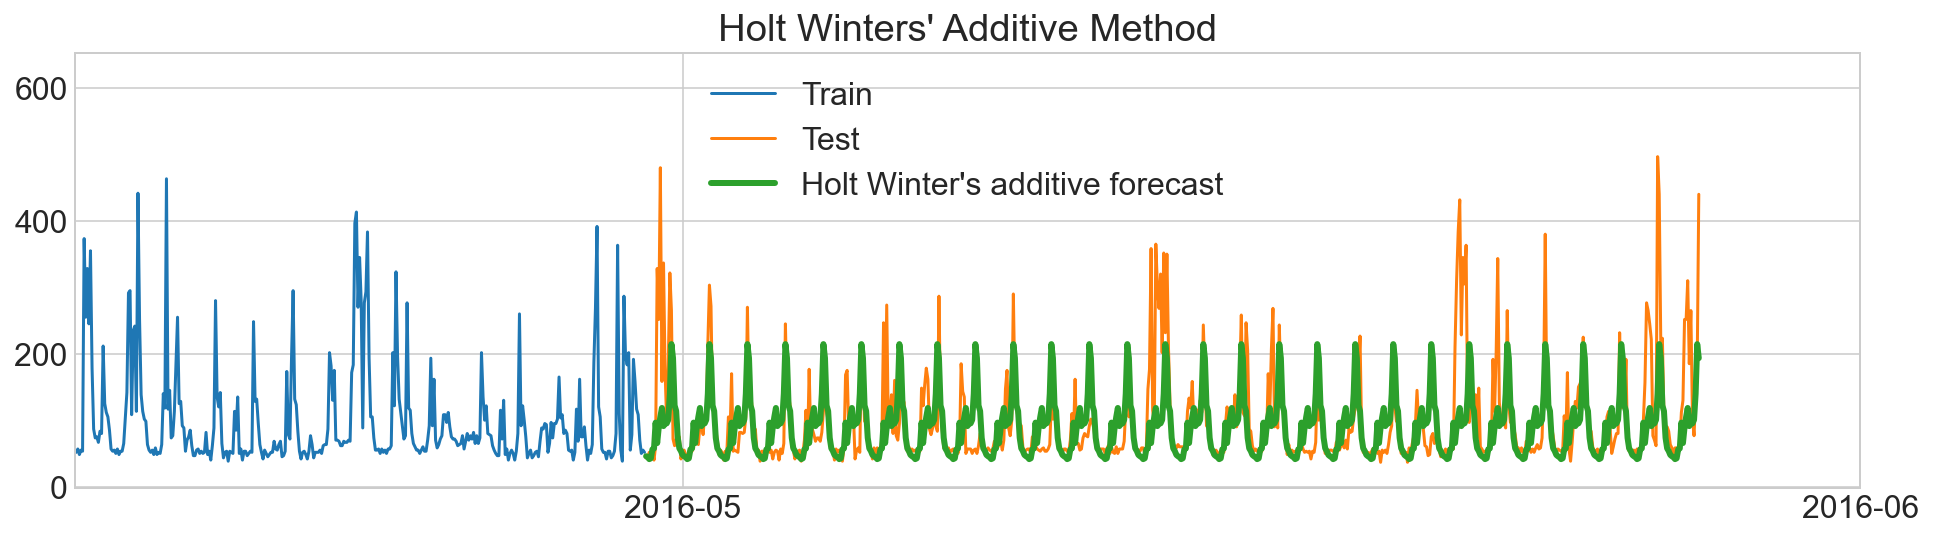

In [33]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winter\'s additive forecast', lw=3)
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [34]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_hwa['hw_forecast'])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8


### Holt Winter's multiplicative method with trend and seasonality

In [35]:
y_hat_hwm = test_df.copy()
model = ExponentialSmoothing(np.asarray(train_df), seasonal_periods=24, trend=None, seasonal='mul')
model_fit = model.fit(optimized=True)

print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test_df))

{'smoothing_level': 0.4057161537408283, 'smoothing_trend': nan, 'smoothing_seasonal': 0.05406302690609297, 'damping_trend': nan, 'initial_level': 125.57374825957709, 'initial_trend': nan, 'initial_seasons': array([2.61517353, 2.15296786, 2.29821075, 2.28172796, 2.40839081,
       1.74406407, 1.32464508, 1.50554388, 1.5051575 , 1.23947817,
       1.27391331, 1.22141248, 1.1765044 , 1.21683576, 2.11044194,
       2.80259527, 3.37208654, 3.17986763, 3.03761665, 2.99668833,
       2.46875718, 2.03114823, 0.6043888 , 1.13486228]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


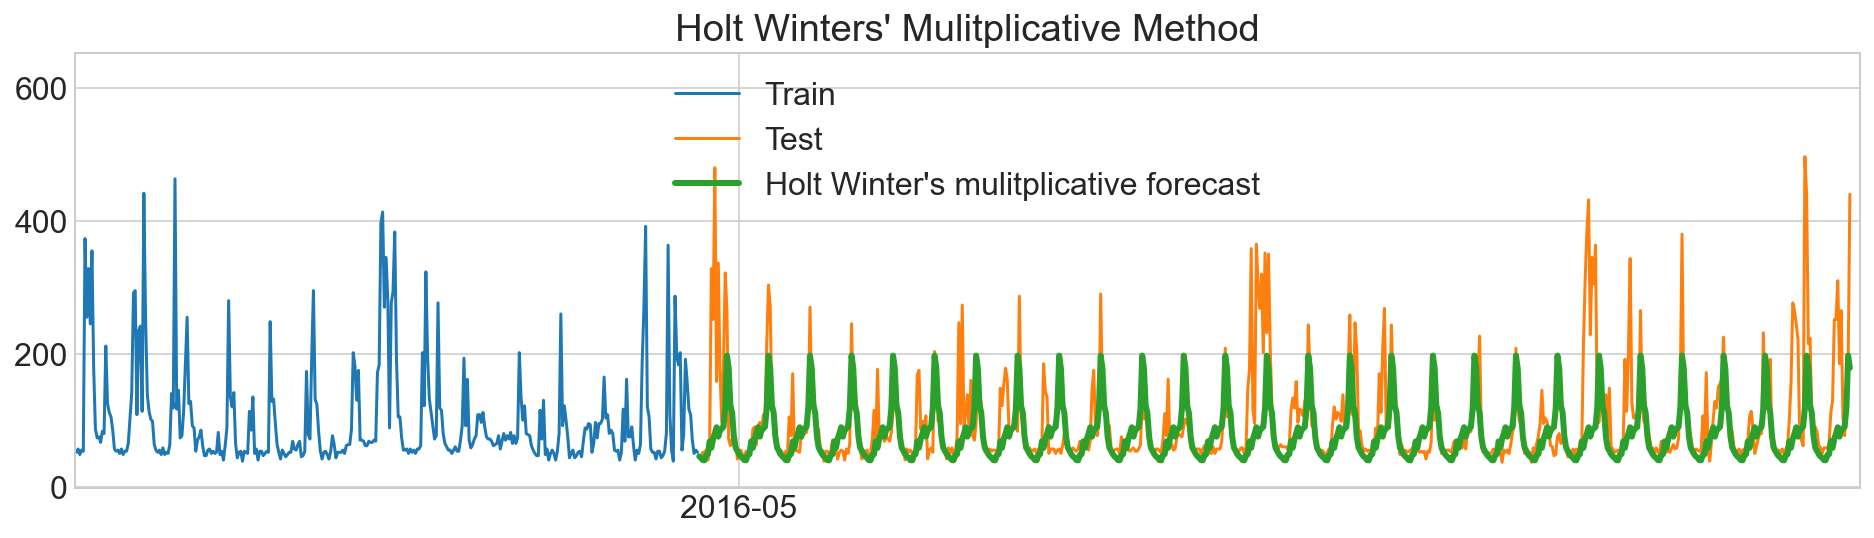

In [39]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winter\'s mulitplicative forecast', lw=3)
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 5, 28)])
plt.show()

In [37]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_hwm['hw_forecast'])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8
0,Holt Winters' multiplicative method,66.2,30.6


**Inference**: Hot Winter's multiplicative winner works best

# Forecasting: Auto Regressive Methods

### Check if time series is stationary

In [40]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(target)

print('ADF Statistic: {:.4f}'.format(adf_test[0]))
print('Critical Values @ 0.05: {:.4f}'.format(adf_test[4]['5%']))
print('p-value: {:.4f}'.format(adf_test[1]))

ADF Statistic: -8.8167
Critical Values @ 0.05: -2.8624
p-value: 0.0000


Inference : p-value is less than 0.05. This means that the series is stationary.

In [41]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(target)

print('KPSS Statistic: {:.4f}'.format(kpss_test[0]))
print('Critical Values @ 0.05: {:.4f}'.format(kpss_test[3]['5%']))
print('p-value: {:.4f}'.format(kpss_test[1]))

KPSS Statistic: 0.1131
Critical Values @ 0.05: 0.4630
p-value: 0.1000


Inference : p-value is more than 0.05. This means that the series is stationary.

### To make the series stationary, we need to perform transformation and differencing (maybe)

Box Cox transformation makes variance constant. Differencing to remove trend

In [42]:
# data_boxcox = pd.Series(boxcox(target['energy'], lmbda=0), index = target.index)
# data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), target.index)

# plt.figure(figsize=(16,4))
# plt.plot(data_boxcox)
# plt.title('After Box Cox transform')
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.show()

# plt.figure(figsize=(16,4))
# plt.plot(data_boxcox_diff)
# plt.title('After Box Cox transform and differencing')
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.show()

In [43]:
# train_data_boxcox = data_boxcox[:TRAIN_LEN]
# test_data_boxcox = data_boxcox[TRAIN_LEN:]

# train_data_boxcox_diff = data_boxcox_diff[:TRAIN_LEN-1]
# test_data_boxcox_diff = data_boxcox_diff[TRAIN_LEN-1:]

### Auto regression method (AR)

In [44]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_df, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      102.5
ar.L1        0.6
sigma2    4836.4
dtype: float64


In [45]:
# Recover original time series

y_hat_ar = target.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(target.index.min(), target.index.max())

# y_hat_ar = data_boxcox_diff.copy()
# y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
# y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
# y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

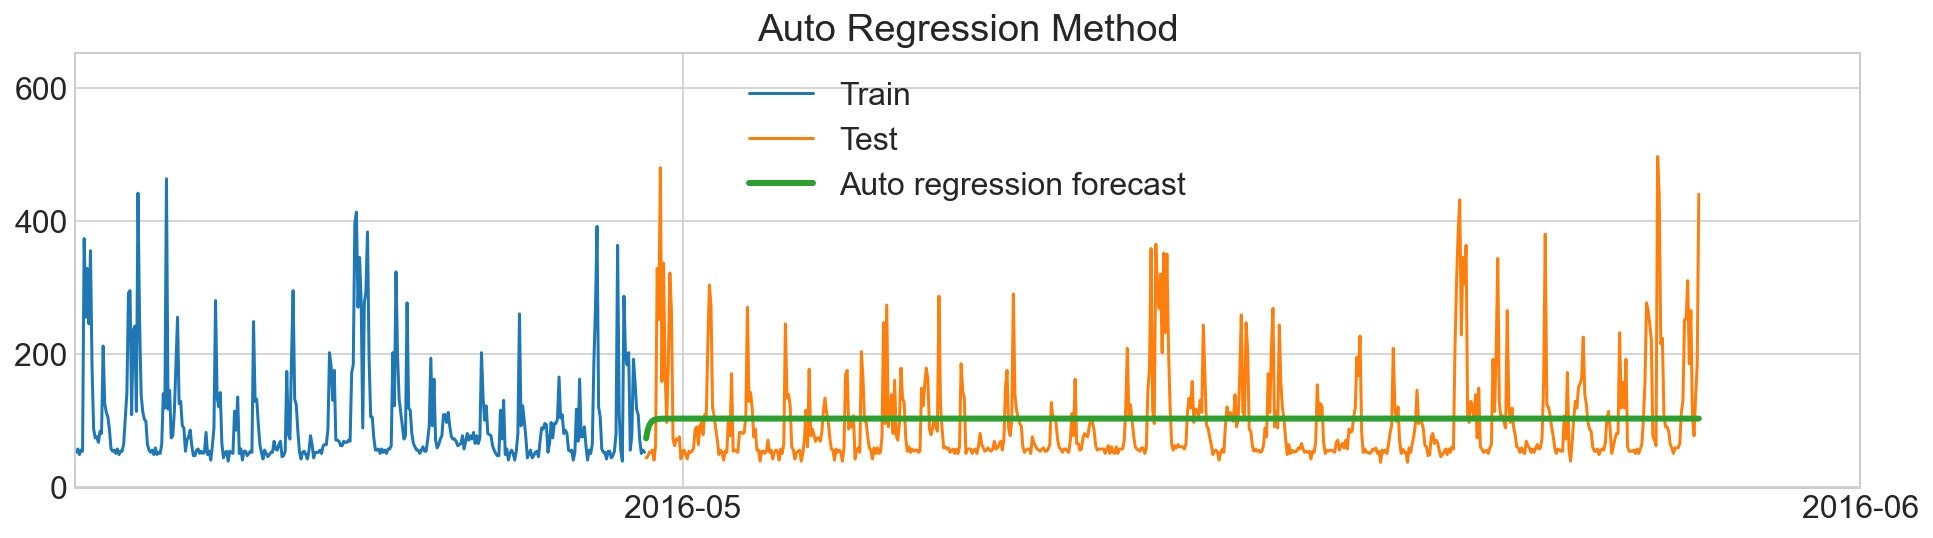

In [46]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test_df.index.min():], label='Auto regression forecast', lw=3)
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [47]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_ar['ar_forecast'][test_df.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_ar['ar_forecast'][test_df.index.min():])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8
0,Holt Winters' multiplicative method,66.2,30.6
0,Autoregressive (AR) method,72.1,59.3


### Moving average method (MA)

In [51]:
model = ARIMA(train_df, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      102.5
ma.L1        0.4
sigma2    5697.6
dtype: float64


In [52]:
# Recover original time series

y_hat_ma = target.copy()
y_hat_ma['ma_forecast'] = model_fit.predict(target.index.min(), target.index.max())

# y_hat_ma = data_boxcox_diff.copy()
# y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
# y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
# y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

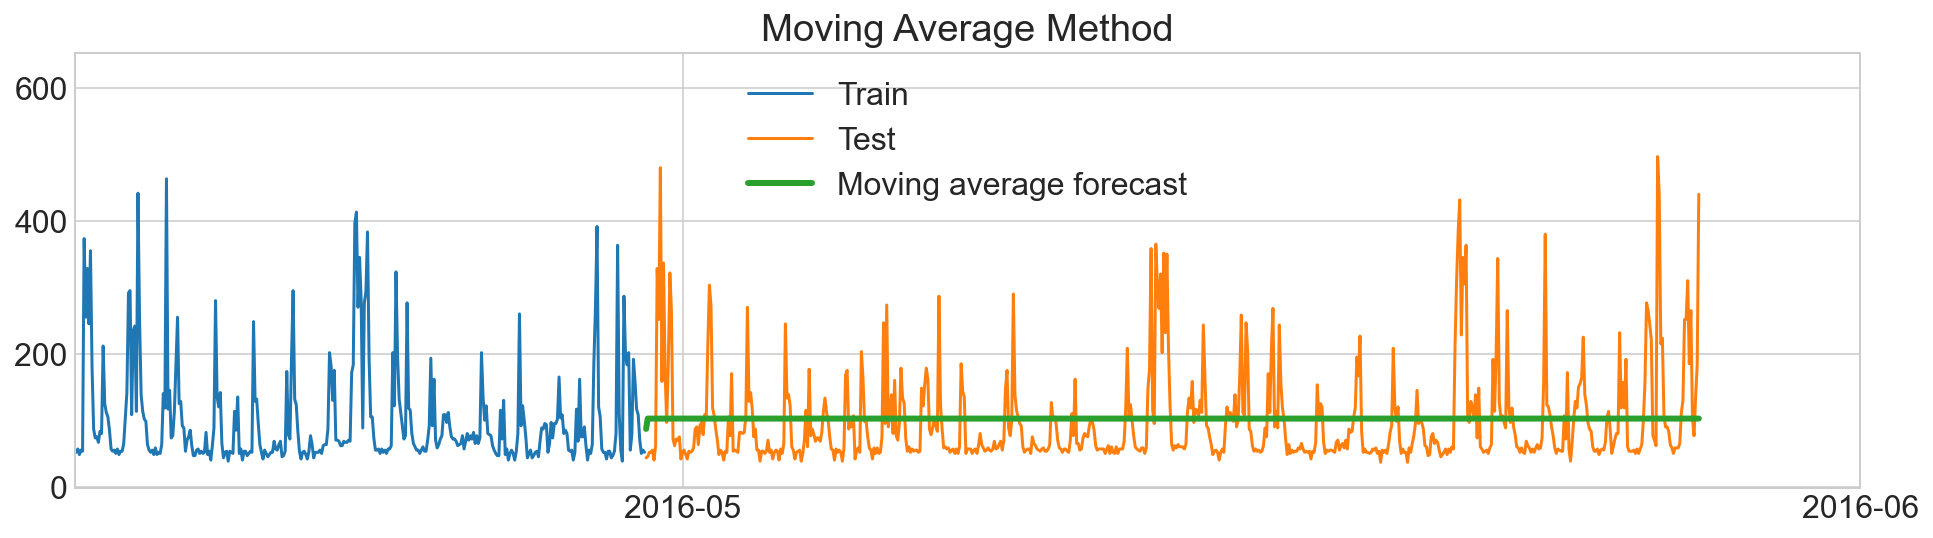

In [53]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test_df.index.min():], label='Moving average forecast', lw=3)
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [54]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_ma['ma_forecast'][test_df.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_ma['ma_forecast'][test_df.index.min():])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8
0,Holt Winters' multiplicative method,66.2,30.6
0,Autoregressive (AR) method,72.1,59.3
0,Moving Average (MA) method,72.1,59.4


### Auto regression moving average method (ARMA)

In [61]:
model = ARIMA(train_df, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      102.5
ar.L1        0.7
ma.L1       -0.2
sigma2    4700.2
dtype: float64


In [59]:
# Recover original time series

y_hat_arma = target.copy()
y_hat_arma['arma_forecast'] = model_fit.predict(target.index.min(), target.index.max())

# y_hat_arma = data_boxcox_diff.copy()
# y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
# y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
# y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

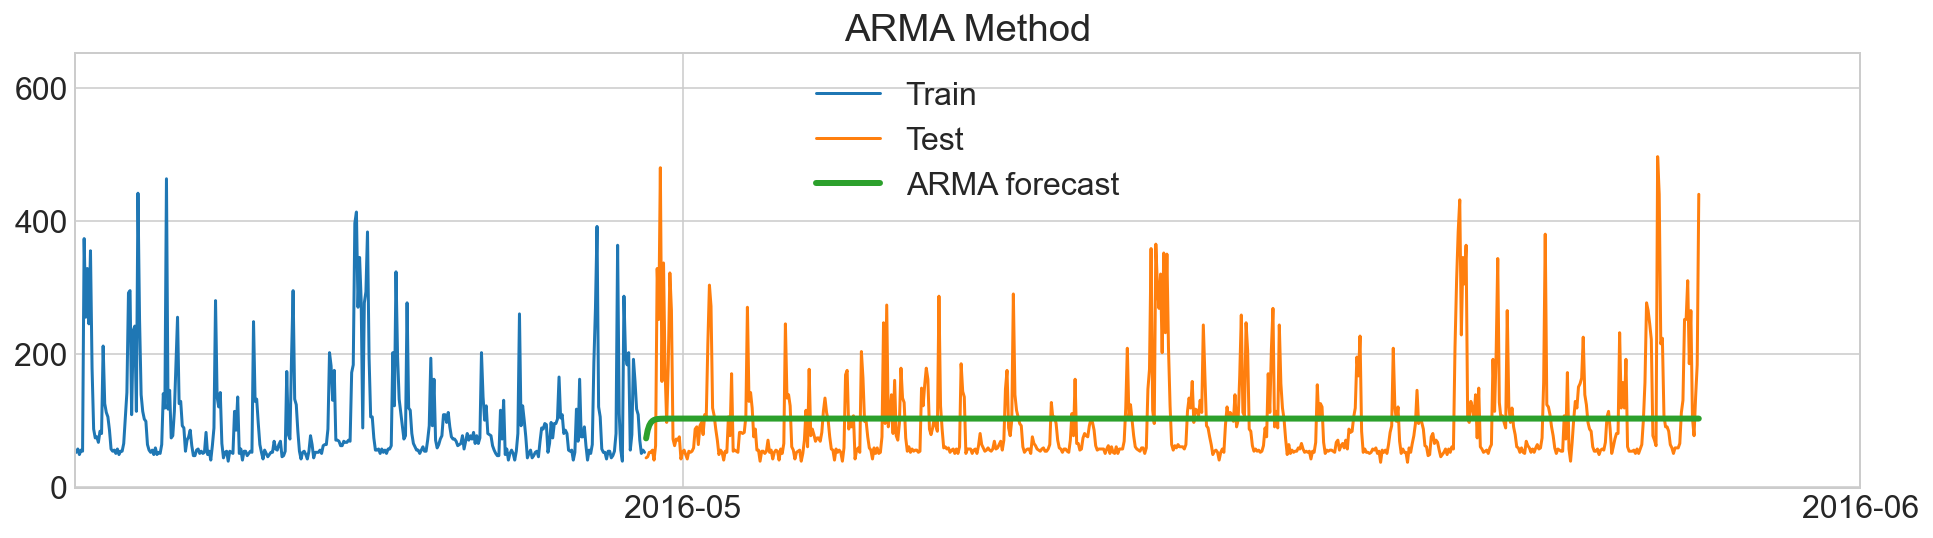

In [60]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test_df.index.min():], label='ARMA forecast', lw=3)
plt.legend(loc='best')
plt.title('ARMA Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [62]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_arma['arma_forecast'][TRAIN_LEN:])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_arma['arma_forecast'][TRAIN_LEN:])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8
0,Holt Winters' multiplicative method,66.2,30.6
0,Autoregressive (AR) method,72.1,59.3
0,Moving Average (MA) method,72.1,59.4
0,Autoregressive moving average (ARMA) method,72.1,59.3


### Auto regressive integrated moving average (ARIMA) 

In [79]:
model = ARIMA(train_df, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

ar.L1        0.6
ma.L1       -1.0
sigma2    4836.7
dtype: float64


In [80]:
# Recover original time series forecast

y_hat_arima = target.copy()
y_hat_arima['arima_forecast'] = model_fit.predict(target.index.min(), target.index.max())

# y_hat_arima = data_boxcox_diff.copy()
# y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
# y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
# y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

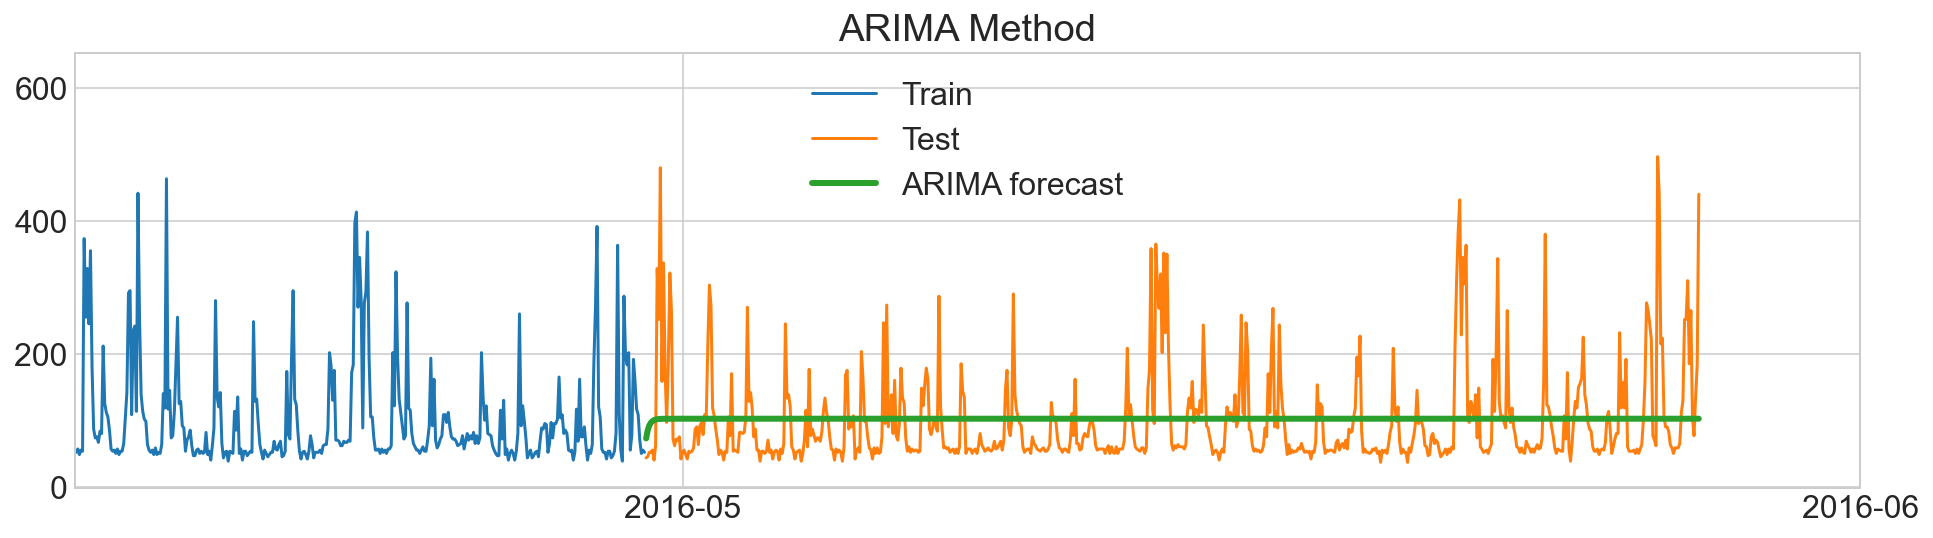

In [81]:
plt.figure(figsize=(16,4))
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test_df.index.min():], label='ARIMA forecast', lw=3)
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 15), datetime.date(2016, 6, 1)])
plt.show()

In [72]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_arima['arima_forecast'][test_df.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_arima['arima_forecast'][test_df.index.min():])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8
0,Holt Winters' multiplicative method,66.2,30.6
0,Autoregressive (AR) method,72.1,59.3
0,Moving Average (MA) method,72.1,59.4
0,Autoregressive moving average (ARMA) method,72.1,59.3
0,Autoregressive integrated moving average (ARIM...,72.1,59.1


### Seasonal auto regressive integrated moving average (SARIMA)

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 1
d = 0
q = 1

P = 1
D = 0
Q = 1
s = 24

model = SARIMAX(train_df, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1          0.8
ma.L1         -0.4
ar.S.L24       1.0
ma.S.L24      -0.9
sigma2      4089.6
dtype: float64


In [93]:
# Recover original time series forecast

y_hat_sarima = target.copy()
y_hat_sarima['sarima_forecast'] = model_fit.predict(target.index.min(), target.index.max())

# y_hat_sarima = data_boxcox_diff.copy()
# y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

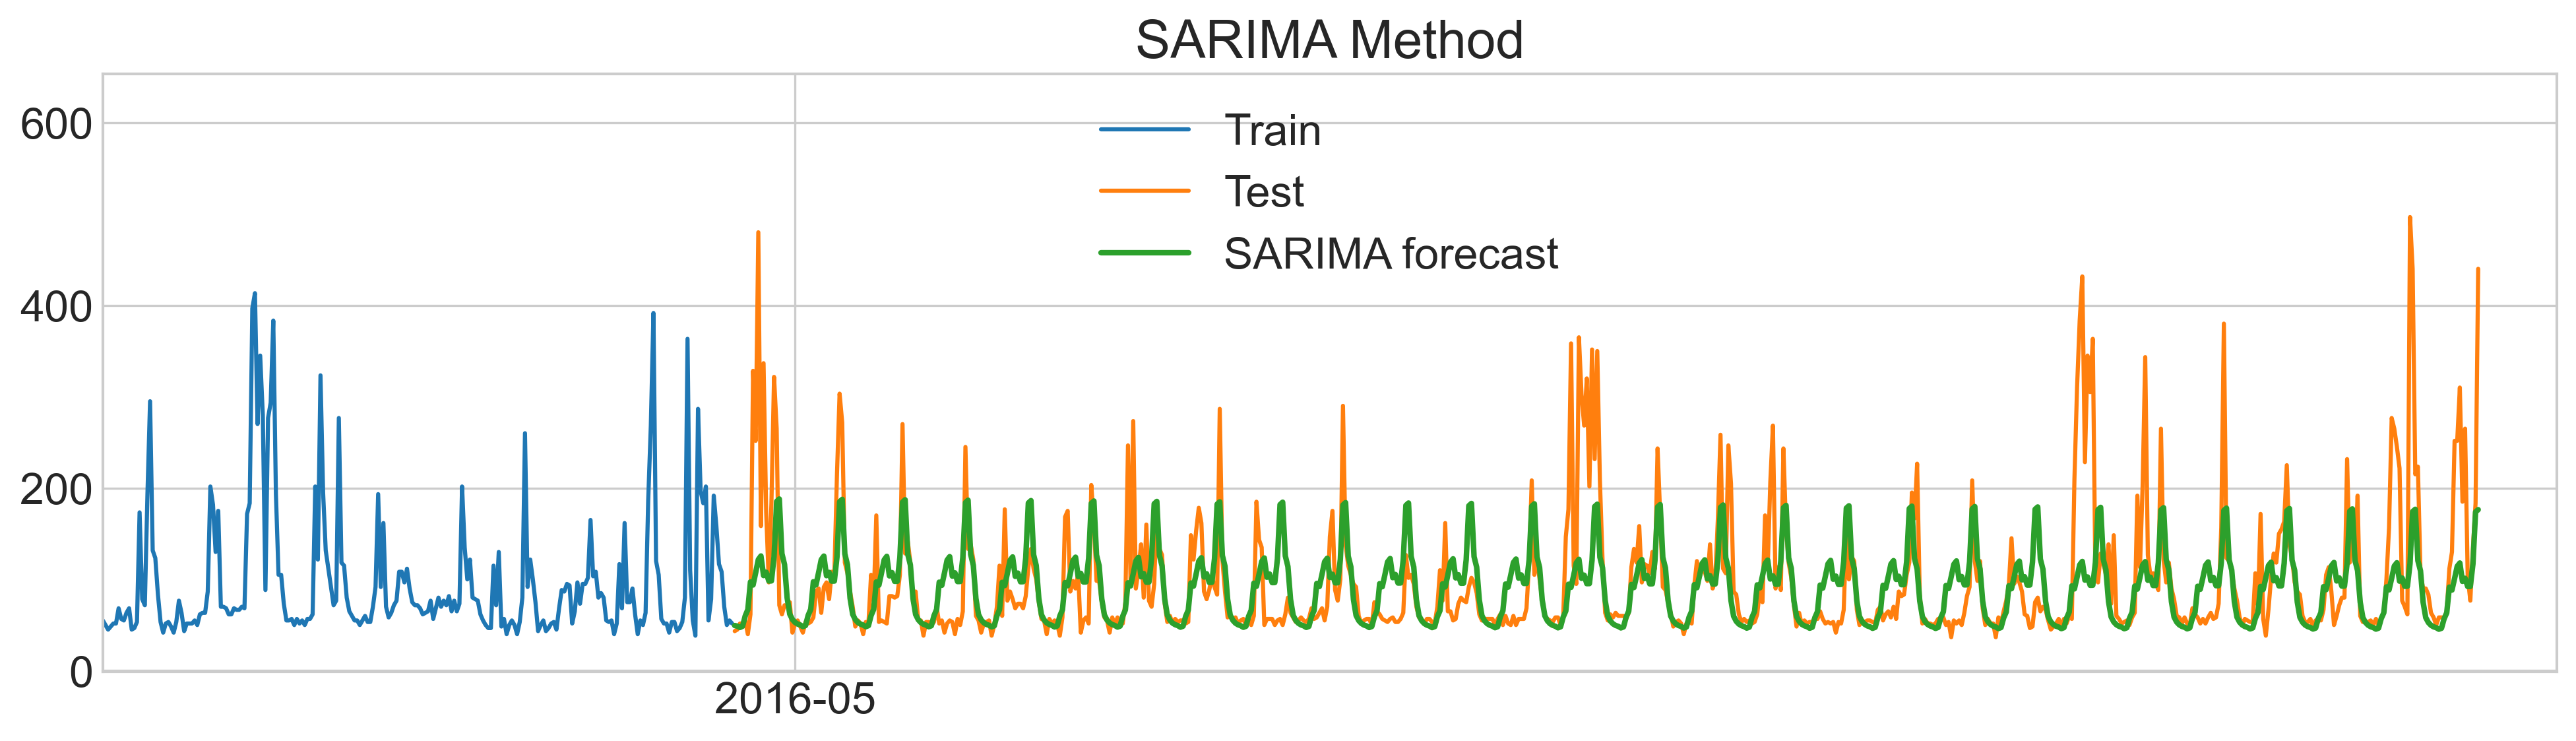

In [94]:
plt.figure(figsize=(16,4), dpi=150)
plt.plot(train_df['energy'], label='Train')
plt.plot(test_df['energy'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_df.index.min():], label='SARIMA forecast', lw=2)
plt.legend(loc='best')
plt.title('SARIMA Method')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2016, 4, 20), datetime.date(2016, 5, 29)])
plt.show()

In [88]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test_df['energy'], y_hat_sarima['sarima_forecast'][test_df.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_df['energy']-y_hat_sarima['sarima_forecast'][test_df.index.min():])/test_df['energy'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple average method,72.2,59.5
0,Simple moving average forecast,73.5,69.9
0,Simple exponential smoothing forecast,83.9,29.8
0,Holt's exponential smoothing method,356.0,378.7
0,Holt Winters' additive method,63.8,34.8
0,Holt Winters' multiplicative method,66.2,30.6
0,Autoregressive (AR) method,72.1,59.3
0,Moving Average (MA) method,72.1,59.4
0,Autoregressive moving average (ARMA) method,72.1,59.3
0,Autoregressive integrated moving average (ARIM...,72.1,59.1


## Conclusion

Best methods are 

1) Holt Winters' additive method

2) Seasonal autoregressive integrated moving average (SARIMA) method